# Comparing fast XGM data from two simultaneous recordings

Here we will look at XGM data that was recorded by the X-ray photon diagnostics group at the same short time interval, but at different locations of the EuXFEL-SASE. We will compare an XGM in SASE1 (XTD2) to another one in SASE3 (XTD10). These data were stored in two different runs, belonging to two different proposals even.  
Conceptually, this section makes use of data-object formats introduced before: Xarray, Pandas Series and Pandas DataFrame.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from karabo_data import RunDirectory

Load the SASE1 run:

In [2]:
sa1_data = RunDirectory('/gpfs/exfel/exp/SA1/201930/p900066/raw/r0009')
sa1_data.info()

# of trains:    6296
Duration:       0:10:29.500000
First train ID: 38227866
Last train ID:  38234161

0 detector modules ()

5 instrument sources (excluding detectors):
  - SA1_XTD2_MCP/ADC/1:channel_3.output
  - SA1_XTD2_MCP/ADC/1:channel_5.output
  - SA1_XTD2_MCP/ADC/1:channel_9.output
  - SA1_XTD2_XGM/XGM/DOOCS:output
  - SPB_XTD9_XGM/XGM/DOOCS:output

8 control sources:
  - SA1_XTD2_MCP/ADC/1
  - SA1_XTD2_MCP/DCTRL/UVLAMP
  - SA1_XTD2_MCP/MOTOR/X1
  - SA1_XTD2_MCP/PSC/MCP1
  - SA1_XTD2_MCP/PSC/MCP2
  - SA1_XTD2_MCP/PSC/PHOTODIODE
  - SA1_XTD2_XGM/XGM/DOOCS
  - SPB_XTD9_XGM/XGM/DOOCS



We are interested in fast, i.e. pulse-resolved data from the instrument source `SA1_XTD2_XGM/DOOCS:output`. As learned in the previous chapter, the ***Xarray*** data class is suited for such data.

In [3]:
sa1_data.keys_for_source('SA1_XTD2_XGM/XGM/DOOCS:output')

{'data.intensityAUXTD',
 'data.intensitySigma.x_data',
 'data.intensitySigma.y_data',
 'data.intensityTD',
 'data.trainId',
 'data.xTD',
 'data.yTD'}

We want the data for quantity `intensityTD`. However, we do not want to work with the complete two-dimensional array, but with an array of first pulses from every train. Numpy offers a very convenient syntax where array dimensions are separated by comma within only one pair of square brackets. In this particular case, the colon means to take all indices of the first dimension (trains), while the zero is an index for a single element in dimension two, that is, the first pulse of each train: 

In [4]:
sa1_flux = sa1_data.get_array('SA1_XTD2_XGM/XGM/DOOCS:output', 'data.intensityTD')
print(sa1_flux.shape)
sa1_pulse_flux = sa1_flux[:,0]
print(sa1_pulse_flux.shape)

(6295, 1000)
(6295,)


Finally we plot the data as line-graph:

Text(0, 0.5, 'intensityTD')

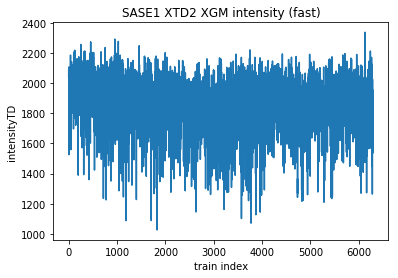

In [5]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(sa1_pulse_flux)
ax.set_title('SASE1 XTD2 XGM intensity (fast)')
ax.set_xlabel('train index')
ax.set_ylabel('intensityTD')

We repeat everything for the second data set from the different run - SASE3:

In [6]:
sa3_data = RunDirectory('/gpfs/exfel/exp/SA3/201930/p900073/raw/r0032')
sa3_data.info()

# of trains:    6236
Duration:       0:10:23.500000
First train ID: 38227850
Last train ID:  38234085

0 detector modules ()

1 instrument sources (excluding detectors):
  - SA3_XTD10_XGM/XGM/DOOCS:output

2 control sources:
  - SA3_BR_UTC/TSYS/TIMESERVER
  - SA3_XTD10_XGM/XGM/DOOCS



In [7]:
sa3_flux = sa3_data.get_array('SA3_XTD10_XGM/XGM/DOOCS:output', 'data.intensityTD')
sa3_pulse_flux = sa3_flux[:,0]
print(sa3_pulse_flux.shape)

(6235,)


Text(0, 0.5, 'intensityTD')

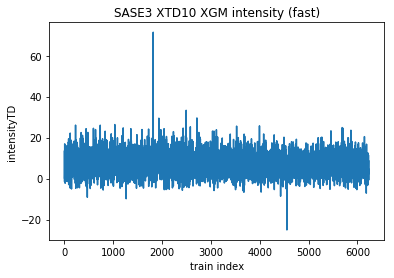

In [8]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(sa3_pulse_flux)
ax.set_title('SASE3 XTD10 XGM intensity (fast)')
ax.set_xlabel('train index')
ax.set_ylabel('intensityTD')

## Aligning and correlating the data

Next, we want to compare the two runs more directly, namely by correlation. From the `run.info()` we have noticed that the two data sets are not of equal size. They are largely overlapping in unique train identifiers, but SASE3 data starts 16 trains earlier, ends 76 trains earlier and thus contains 60 trains less overall.

In order to combine the two runs into one "data table" with matching trains, a Pandas ***DataFrame*** object is a very good option. We will first export the single-pulse Xarray data to Pandas ***Series*** and then concatenate these. Concatenation with Pandas can be done by providing the two input data *Series* as a list, or as a dictionary with key-value pairs, which has the advantage that we will obtain named data columns in the *DataFrame*, as per the keys provided.  

Because of the train-range inconsistency, we also need to match the trains. There are two ways of achieving this with Pandas. Pandas will align data automatically upon concatenation, implicitly *expanding* it where neccessary to produce the union. This means that rows with unmatched train-Ids in either column will be filled with NaN in the complementary column.  
Here, we will instead explicitly *reduce* the data to its intersection, meaning that trains for which only one column contains data are dropped. That's achieved with the keyword `join='inner'`, and the intersection consists of 6218 trains:

In [9]:
import pandas as pd

sa1_pulse_flux_pd = sa1_pulse_flux.to_series()
sa3_pulse_flux_pd = sa3_pulse_flux.to_series()

sa1_sa3 = pd.concat({
 'SA1_XTD2_XGM.intensityTD': sa1_pulse_flux_pd,
 'SA3_XTD10_XGM.intensityTD': sa3_pulse_flux_pd,
}, axis=1, join='inner')

print(sa1_sa3.shape)
sa1_sa3.head(5)

(6218, 2)


,SA1_XTD2_XGM.intensityTD,SA3_XTD10_XGM.intensityTD
trainId,,
38227866,2045.128662,5.927809
38227867,2091.464355,8.840389
38227868,1872.964722,7.313530
38227869,1854.730591,5.530055
38227870,1980.810547,2.412182


Finally we will plot the correlation of the two:

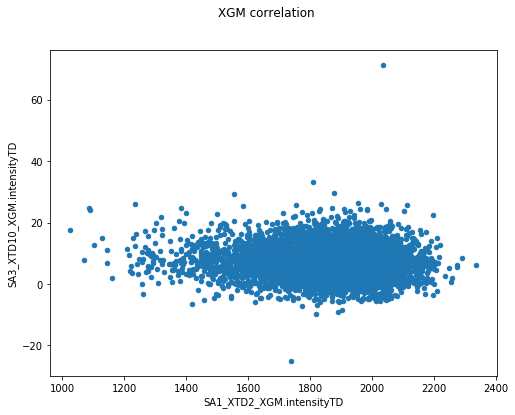

In [10]:
fig = plt.figure(figsize=(8,6))
fig.suptitle('XGM correlation')
ax = fig.add_subplot(1,1,1)
sa1_sa3.plot.scatter(x='SA1_XTD2_XGM.intensityTD', y='SA3_XTD10_XGM.intensityTD', ax=ax)